# 1. 라이브러리 불러오기

In [1]:
import torch
import numpy as np
from torch import nn
import os
import matplotlib.pyplot as plt
import cv2
import copy
from torchvision import transforms, models
from ipywidgets import interact
from torch.utils.data import Dataset, DataLoader

# 2. 이미지 파일 경로 불러오기

In [2]:
# 코로나, 정상, 폐렴 폴더가 달라서 합쳐주는 함수
def list_image_file(data_dir, sub_dir): 
    # 이미지 포맷 정해줌
    image_format = ['jpeg', 'jpg', 'png']
    images_files = [] # 불러와서 저장할 예정
    
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format: # 앞은 파일 이름, 뒤는 확장명.
            images_files.append(os.path.join(sub_dir, file_path))
    return images_files

In [3]:
data_dir = './Covid19-dataset/train/'

normals_list = list_image_file(data_dir, 'Normal')
covids_list = list_image_file(data_dir, 'Covid')
pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [4]:
print(len(normals_list))
print(len(covids_list))
print(len(pneumonias_list))

70
111
70


# 3. 이미지 파일을 RGB 3차원 배열로 불러오기

In [5]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name) # 붙여서 경로 만들기
    image = cv2.imread(image_file) # 경로 넣어서 파일 불러오기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# 4. 이미지 데이터 시각화하기

In [6]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))

@interact(index=(0, min_num_files-1)) # 70개니까 0부터 69까지
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    print(data_dir)
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 5. 학습 데이터셋 클래스 만들기

In [7]:
train_data_dir = './Covid19-dataset/train/'
class_list = ['Covid', 'Normal', 'Viral Pneumonia']

In [8]:
# 데이터를 효율적으로 모델에게 전달하기 위해(예:배치사이즈) 데이터셋과 데이터로더 만듦
class Chest_dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        normals = list_image_file(data_dir, 'Normal')
        covids = list_image_file(data_dir, 'Covid')
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        self.files_path = normals + covids + pneumonias # 리스트들을 합쳐줌
        self.transform = transform
        
    def __len__(self):
        return len(self.files_path)
        
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = class_list.index(self.files_path[index].split(os.sep)[-2]) # 행렬에서 정답을 가져옴
        target = class_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()
            
        return {'image':image, 'target':target}

In [9]:
dset = Chest_dataset(train_data_dir)

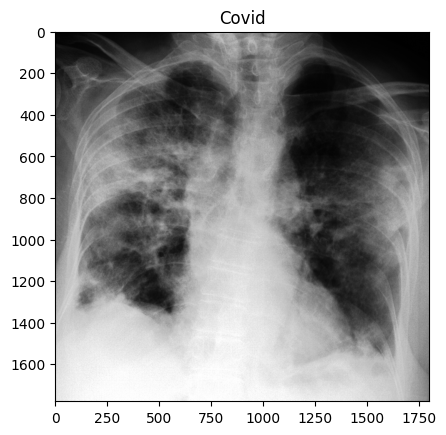

In [10]:
index = 100
plt.title(class_list[dset[index]['target']])
plt.imshow(dset[index]['image'])

# 6. 배열을연산가능한 텐서로 변환하기

In [11]:
# Compose() : 한꺼번에 여러 개를 어떤 거에 적용하기 위한 함수
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)), # # 이후 사용할 모델의 입력값 크기에 맞춰서
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5]) # RGB를 0과 1사이로 만들어줌
])

In [12]:
train_dset = Chest_dataset(train_data_dir, transformer)

In [13]:
index = 200
image = train_dset[index]['image']
label = train_dset[index]['target']

In [14]:
print(image.shape, label)

torch.Size([3, 224, 224]) tensor([2])


# 7. 데이터로더 구현하기

In [15]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
    
    val_dset = Chest_dataset(val_data_dir, transformer)
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [16]:
train_data_dir = './Covid19-dataset/train/'
val_data_dir = './Covid19-dataset/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [17]:
for i, d in enumerate(dataloaders['train']):
    print(i,d)
    if i == 0:
        break

0 {'image': tensor([[[[-0.9686, -0.9759, -0.9618,  ...,  0.9922,  0.9989,  1.0000],
          [-0.9529, -0.9608, -0.9529,  ...,  0.9922,  1.0000,  1.0000],
          [-0.9529, -0.9554, -0.9608,  ...,  0.9922,  1.0000,  1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,  0.7564,  0.8926,  0.9071],
          [-1.0000, -1.0000, -1.0000,  ...,  0.8476,  0.7229,  0.8678],
          [-1.0000, -1.0000, -1.0000,  ...,  0.9309,  0.8577,  0.8086]],

         [[-0.9686, -0.9759, -0.9618,  ...,  0.9922,  0.9989,  1.0000],
          [-0.9529, -0.9608, -0.9529,  ...,  0.9922,  1.0000,  1.0000],
          [-0.9529, -0.9554, -0.9608,  ...,  0.9922,  1.0000,  1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,  0.7564,  0.8926,  0.9071],
          [-1.0000, -1.0000, -1.0000,  ...,  0.8476,  0.7229,  0.8678],
          [-1.0000, -1.0000, -1.0000,  ...,  0.9309,  0.8577,  0.8086]],

         [[-0.9686, -0.9759, -0.9618,  ...,  0.9922,  0.9989,  1.0000],
          [-0.9529

In [18]:
d['target'].shape

torch.Size([4, 1])

In [19]:
d['target'].squeeze()

tensor([1, 0, 1, 2])

# 8. Classification 모델(VGG19) 불러오기

In [20]:
model = models.vgg19(pretrained=True)

C:\Users\82103\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\82103\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
from torchsummary import summary

In [22]:
summary(model, (3, 244, 244), batch_size=1, device='cpu') # 데이터를 넣었을 때 모델이 어떻게 되는지를 보는 것

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 244, 244]           1,792
              ReLU-2          [1, 64, 244, 244]               0
            Conv2d-3          [1, 64, 244, 244]          36,928
              ReLU-4          [1, 64, 244, 244]               0
         MaxPool2d-5          [1, 64, 122, 122]               0
            Conv2d-6         [1, 128, 122, 122]          73,856
              ReLU-7         [1, 128, 122, 122]               0
            Conv2d-8         [1, 128, 122, 122]         147,584
              ReLU-9         [1, 128, 122, 122]               0
        MaxPool2d-10           [1, 128, 61, 61]               0
           Conv2d-11           [1, 256, 61, 61]         295,168
             ReLU-12           [1, 256, 61, 61]               0
           Conv2d-13           [1, 256, 61, 61]         590,080
             ReLU-14           [1, 256,

In [23]:
model # 모델에 대해 print 가능

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# 9. 데이터에 맞게 모델 Head 부분을 수정하기

In [24]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, len(class_list)),
    nn.Sigmoid()
)

In [25]:
def build_vgg19_based_model(device_name='cpu'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_list)),
        nn.Softmax(dim=1) # 결과를 하나로
    )
    return model.to(device)

In [26]:
model = build_vgg19_based_model(device_name='cpu')

In [27]:
summary(model, (3, 244, 244), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 244, 244]           1,792
              ReLU-2          [1, 64, 244, 244]               0
            Conv2d-3          [1, 64, 244, 244]          36,928
              ReLU-4          [1, 64, 244, 244]               0
         MaxPool2d-5          [1, 64, 122, 122]               0
            Conv2d-6         [1, 128, 122, 122]          73,856
              ReLU-7         [1, 128, 122, 122]               0
            Conv2d-8         [1, 128, 122, 122]         147,584
              ReLU-9         [1, 128, 122, 122]               0
        MaxPool2d-10           [1, 128, 61, 61]               0
           Conv2d-11           [1, 256, 61, 61]         295,168
             ReLU-12           [1, 256, 61, 61]               0
           Conv2d-13           [1, 256, 61, 61]         590,080
             ReLU-14           [1, 256,

# 10. 손실함수 불러오기

In [28]:
# 크로스엔트로피는 분류에 쓰임.
# mean으로 해서 
loss_func = nn.CrossEntropyLoss(reduction='mean')

# 11. Gradient 최적화 함수 불러오기

In [29]:
# momentum : 가속을 붙임. 경사가 급한 곳에서는 급하게.
# 필요한 곳에서는 빠르게, 섬세하게 진행 가능
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# 12. 모델 검증을 위한 Accuracy 생성하기

In [30]:
# 가중치를 업데이트할 때 굉장히 리소스를 많이 필요함
# 지금은 검증을 위한 함수이므로, 학습을 위한 것들은 꺼줌
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1) # 가장 확률이 놓은 걸 출력
    is_correct = (pred_label == target) # 같으면 true
    return is_correct.cpu().numpy().sum() / batch_size # 배치 사이즈 당 몇 개나 맞췄는지

# 13. 모델 학습을 위한 함수 구현하기

In [31]:
device = torch.device('cpu')

In [32]:
# 학습과 검증을 동시에 진행
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    
    for tv in ['train', 'val']: # train일 때 한번, val일 때 한번 돌게 됨
        running_loss = 0.0
        running_correct = 0.0
        
        if tv == 'train':
            model.train()
        else:
            model.eval() # off
            
        for index, batch in enumerate(dataloaders[tv]): # train일때는 train의 dataloader만 뽑아서 진행
            image = batch['image'].to(device)
            target = batch['target'].squeeze(dim=1).to(device)
            
            # grad를 세팅. train일 때는 필요하고, val일때는 필요없음
            with torch.set_grad_enabled(tv == 'train'): # train일때는 켜줌
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if tv == 'train':
                    # 학습
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if tv == 'train':
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")

        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    
    return losses, accuracies 

In [33]:
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True) # 존재하지 않으면 새로 만들고, 존재하면 덮어쓴다
    torch.save(model_state, os.path.join(save_dir, model_name))

# 14. 모델 학습 수행하기

In [34]:
device = torch.device('cpu')

train_data_dir = 'Covid19-dataset/train/'
val_data_dir = 'Covid19-dataset/test/'

dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name='cpu')
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [135]:
# 에폭 돌릴 때마다 위위 함수 실행
num_epochs = 10

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")

    if {epoch > 3} and {accuracies['val'] > best_acc}:
        best_acc = accuracies['val']
        # deepcopy : 배열의 내부 객체까지 복사를 해서 사용
        # copy : 배열의 내부 객체까지 깊은 복사를 해주지 않음
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')
        
print(f'Best Accuracy: {best_acc}')

0/62 - Running loss: 0.6732337474822998
10/62 - Running loss: 0.6320185661315918
20/62 - Running loss: 1.007727026939392
30/62 - Running loss: 0.729812741279602
40/62 - Running loss: 0.587894082069397
50/62 - Running loss: 0.7720683813095093
60/62 - Running loss: 0.8018219470977783
1/10-Train Loss:0.746682632353998, Val Loss:0.8641787631945177
1/10-Train Acc:0.8508064516129032, Val Acc:0.696969696969697
0/62 - Running loss: 0.8015084266662598
10/62 - Running loss: 1.0650465488433838
20/62 - Running loss: 1.033818244934082
30/62 - Running loss: 1.0870414972305298
40/62 - Running loss: 0.5853993892669678
50/62 - Running loss: 0.5655204057693481
60/62 - Running loss: 0.5925885438919067
2/10-Train Loss:0.7964891935548475, Val Loss:0.7752228559869708
2/10-Train Acc:0.782258064516129, Val Acc:0.7424242424242424
0/62 - Running loss: 0.5554584264755249
10/62 - Running loss: 0.6712678670883179
20/62 - Running loss: 0.7207268476486206
30/62 - Running loss: 1.0591915845870972
40/62 - Running loss

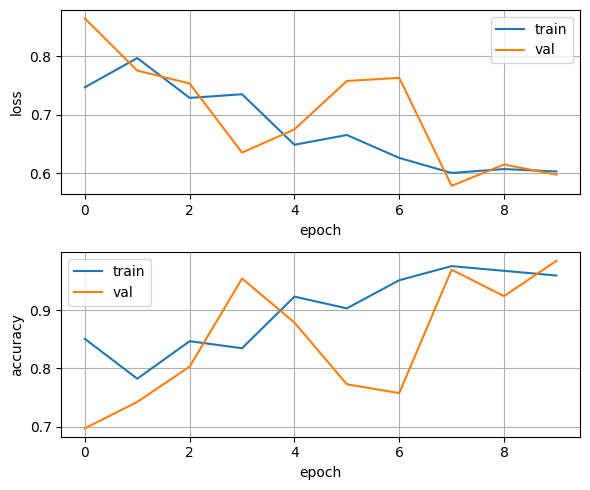

In [136]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()

# 15. 테스트 이미지를 통한 학습 모델 분류 성능 검증하기

In [35]:
data_data = './Covid19-dataset/test/'
class_list = ['Covid', 'Normal', 'Viral Pneumonia']

test_normals_list = list_image_file(data_dir, 'Normal')
test_covids_list = list_image_file(data_dir, 'Covid')
test_pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [36]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    tensor_image = transformer(image) # (C, H, W)
    # 학습할 때 배치로 돌아서 예측할 때도 batch가 필요함
    tensor_image = tensor_image.unsqueeze(0) # (B, C, H, W) # 0번째 차원을 늘린것
    return tensor_image

In [46]:
def model_predict(image,model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    
    _, pred_label = torch.max(prediction.detach(), dim=1) # dim=1: 1차원으로 가져옴. 데이터 하나짜리.
    print("pred_laebel1: ", pred_label)
    pred_label = pred_label.squeeze(0) # 0번 차원을 제거. # 단순히 label값을 출력하기 위해 차원을 줄임
    print("pred_laebel2: ", pred_label)
    return pred_label.item()

In [47]:
ckpt = torch.load('./trained_model/model_10.pth')

model = build_vgg19_based_model(device_name='cpu')
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [48]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list)) # 최소값을 맞춤

@interact(index=(0, min_num_files-1))
def show_result(index=0): # 실제값과 예측값을 비교해보자
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f'Pred:{class_list[prediction_1]} | GT:Normal')
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title(f'Pred:{class_list[prediction_2]} | GT:Covid')
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title(f'Pred:{class_list[prediction_3]} | GT:Pneumonia')
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

1. 이미지 데이터셋 구축
2. Torchvision transforms 라이브러리를 활용한 텐서형 데이터 변형
3. VGG19 모델을 불러와 Head 부분을 수정
4. Cross entropy Loss Function과 SGDM을 적용
5. 인간 추론 원리와 닮은 딥러닝 결과